# LDA Model (Number Recognition)

* Outline

1. Introduction
2. EDA
3. Dimensionality Reduction
4. LDA (in R)
5. Naive Bayes
6. QDA

## 1. Introduction

* Here, I attempt to use develop a number recognition classifier. I will try 3 different methods, i.e. LDA, Bayes, Naive Bayes and QDA. I will evaluate in greater detail the results of the LDA and its effectiveness to be used as a classifier in the Project Report.

* Dataset used is the MNIST Dataset, 42000 observations, each observation is an image of 28 by 28 pixel values, each pixel have a value of 0 to 255, denoting the color brightness of the pixels.

#### Set up

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import random
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
from keras.layers import Input, Dense
from keras.models import Model
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

2023-04-06 23:48:05.591186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# read datasets
data = pd.read_csv("./data/train.csv")

In [3]:
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
random.seed(10)

# split into train and test set
train = data.sample(frac = 0.8)
xtrain = train.iloc[:, 1:]
ytrain = train.iloc[:, 0]

test = data.drop(train.index)
xtest = test.iloc[:, 1:]
ytest = test.iloc[:, 0]

In [5]:
print(f"Shape of xtrain set : {xtrain.shape}")
print(f"Shape of ytrain set : {ytrain.shape}")
print(f"Shape of xtest set : {xtest.shape}")
print(f"Shape of ytest set : {ytest.shape}")

Shape of xtrain set : (33600, 784)
Shape of ytrain set : (33600,)
Shape of xtest set : (8400, 784)
Shape of ytest set : (8400,)


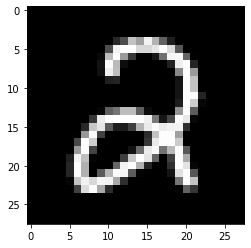

In [6]:
# visualize one image
idx = 0 # change idx for different images
image = xtrain.iloc[idx, :].to_numpy().reshape(28, 28)
fig = plt.figure()
plt.imshow(image, cmap = 'gray')
plt.show()

In [7]:
# read out the files
xtrain.to_csv("./data/xtrain.csv", index = False)
ytrain.to_csv("./data/ytrain.csv", index = False)
xtest.to_csv("./data/xtest.csv", index = False)
ytest.to_csv("./data/ytest.csv", index = False)

## 2. EDA
* Frequency count for the prior distribution of the frequecy of each class

* 2 main underlying assumptions for LDA to work:
    1. Equal covariance matrix between classes (boxM test)
    2. X-variables multivariate normally distributed (MVN test)

* Check singularity of covariance matrix

Text(0.5, 1.0, 'Frequency count of each digit')

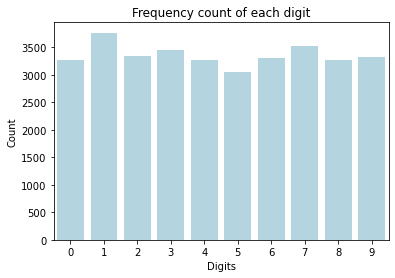

In [8]:
# Frequency count
tbl_count = pd.DataFrame(train['label'].value_counts(sort = False)).sort_index()
idx = [0,1,2,3,4,5,6,7,8,9]
tbl_count['values'] = idx
sns.barplot(data = tbl_count, x = 'values', y = 'label', color = 'lightblue')
plt.xlabel("Digits")
plt.ylabel("Count")
plt.title("Frequency count of each digit")

In [9]:
tbl_count.columns = ['values', 'labels']
tbl_count['values'] = tbl_count['values']/33600
prop_chance = (tbl_count['values']**2).sum()
prop_chance

0.1002929758361678

* repeat code below by replacing 0 with other digits from 1 to 9 and all covariance matrices have a determinant of 0, indicating it is singular

In [10]:
# check for singular matrices for raw data
xtrain0 = train[train['label'] == 0].drop('label', axis = 'columns')
c0 = np.cov(xtrain0.T)
print(f"Is the covariance matrix singular? {np.linalg.det(c0) == 0}")

Is the covariance matrix singular? True


**Using the raw training data and the encoded training data (if results in singular matrices)**

* Check for multivariate normality among x-variable (MVN test in R)
* Check for equal covariance matrix (boxM in R)

## 3. Dimensionality Reduction

**Autoencoders**

High dimensionality exists, 784 dimensions for each observation, therefore I have to use an autoencoder. Autoencoders shrink the dimensionality of the data, whilst retaining the information of each observation. In this case, I choose to shrink the dimensions down from 784 to 32 dimensions.

I will also extract the encoded layer of data to be used as the training and testing data.
* Training data shape (33600, 32)
* Testing data shape (8400, 32)

In [11]:
# Normalize the pixel values to be between 0 and 1
xtrain = xtrain.astype('float32') / 255
xtest = xtest.astype('float32') / 255
input_shape = (784,)

# Define the autoencoder model
encoding_dim = 32
input_img = Input(shape=input_shape)
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder model
autoencoder.fit(xtrain, xtrain,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(xtest, xtest))

2023-04-06 23:48:20.698299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3294 - val_loss: 0.2290
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.2037 - val_loss: 0.1852
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.1737 - val_loss: 0.1638
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.1562 - val_loss: 0.1495
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.1440 - val_loss: 0.1390
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.1346 - val_loss: 0.1305
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.1268 - val_loss: 0.1234
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.1202 - val_loss: 0.1174
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.1149 - val_loss: 0.1128
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.1108 - val_loss: 0.1092

In [12]:
# Extract the reduced-dimensional data
encoder = Model(input_img, encoded)
encoded_imgs_train = encoder.predict(xtrain)
encoded_imgs_test = encoder.predict(xtest)

df_encoded_train = pd.DataFrame(encoded_imgs_train)
df_encoded_test = pd.DataFrame(encoded_imgs_test)
print(f"Shape of df_encoded_train set : {df_encoded_train.shape}")
print(f"Shape of df_encoded_test set : {df_encoded_test.shape}")


263/263 [==============================] - 0s 697us/step
Shape of df_encoded_train set : (33600, 32)
Shape of df_encoded_test set : (8400, 32)


In [13]:
df_encoded_train.to_csv("./data/df_encoded_train.csv", index = False)
df_encoded_test.to_csv("./data/df_encoded_test.csv", index = False)

In [14]:
df_encoded_train.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,6.423843,7.644963,4.920778,16.138390,4.508004,6.296636,10.089787,13.420168,3.575215,10.719762,...,1.963084,6.269075,7.405996,1.815881,6.169482,13.527259,5.717188,5.177960,7.926371,12.189811
1,7.765126,2.104516,9.312441,12.177822,9.144053,6.784928,3.143901,6.602060,10.447847,9.085675,...,3.891644,5.771590,9.286257,8.104121,6.493708,4.771928,9.365100,7.184371,5.306705,5.186380
2,8.491624,10.138547,10.385208,8.412781,12.844549,6.183139,5.481466,4.528965,7.294444,2.877503,...,2.879460,6.306383,6.061527,10.203158,10.558754,6.030228,10.445556,7.319908,3.920482,10.192712
3,7.230186,10.416851,4.663076,3.367588,8.349595,4.072560,2.592229,4.209902,4.572422,5.348343,...,3.600153,0.250067,5.220105,4.788765,3.471257,5.190424,1.609368,0.628603,0.000000,6.967129
4,5.850327,8.780019,8.326383,5.616183,10.259413,4.779061,2.699199,3.037944,4.739063,4.681864,...,4.566665,4.298056,4.788322,8.630564,8.994835,6.106803,7.584591,5.904902,3.211498,9.069920


In [15]:
df_encoded_test.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,10.035125,10.991277,16.802387,7.494188,18.112381,13.271697,12.901682,15.645285,6.105656,7.455058,...,4.749441,11.530614,9.684888,12.763666,14.892500,14.669196,9.638679,6.571511,13.047443,23.532654
1,14.639438,4.523310,13.042906,15.659224,12.161056,7.372672,10.215974,4.436728,8.476017,15.889065,...,10.474258,9.379148,10.362721,13.831975,11.260900,6.627495,11.683720,5.616674,9.855424,15.009304
2,3.468260,1.835862,8.247299,10.389553,10.961897,11.825720,10.496116,2.566545,4.925045,17.628561,...,9.803804,14.192845,7.648024,12.249847,4.948720,4.827621,11.894588,11.610629,7.766128,4.934424
3,7.309656,9.999122,6.809102,7.564864,12.338875,5.278571,2.677884,6.937067,7.733971,0.463764,...,1.002972,3.500668,5.848024,7.188056,6.112298,5.940150,5.969718,3.156946,3.164163,8.505183
4,13.938457,5.574112,6.772978,8.491537,6.674891,3.953596,10.555237,6.968955,3.419969,14.031249,...,9.773300,6.675524,8.127433,7.174528,9.292811,5.107313,7.150223,3.881344,5.707117,6.377589


In [16]:
# Extract the decoded data
decoder = Model(input_img, decoded)
decoded_imgs_train = decoder.predict(xtrain)
#decoded_imgs_test = decoder.predict(xtest)

df_decoded_train = pd.DataFrame(decoded_imgs_train)
#df_decoded_test = pd.DataFrame(encoded_imgs_test)
print(f"Shape of df_decoded_train set : {df_decoded_train.shape}")
#print(f"Shape of df_decoded_test set : {df_decoded_test.shape}")

1050/1050 [==============================] - 1s 780us/step
Shape of df_decoded_train set : (33600, 784)


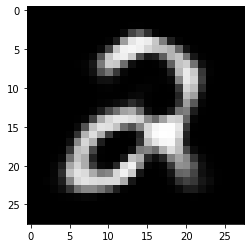

In [17]:
# visualize one reconstucted image
idx = 0 # change idx for different images
image = df_decoded_train.iloc[idx, :].to_numpy().reshape(28, 28)
fig = plt.figure()
plt.imshow(image, cmap = 'gray')
plt.show()

In [18]:
ytrain = ytrain.reset_index(drop=True)
ytest = ytest.reset_index(drop=True)

## 4. LDA Classifier

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# create model
lda = LinearDiscriminantAnalysis()
lda.fit(df_encoded_train, ytrain)

# predictions
trg_pred = lda.predict(df_encoded_train)
trg_acc = accuracy_score(ytrain, trg_pred)

test_pred = lda.predict(df_encoded_test)
test_acc = accuracy_score(ytest, test_pred)

print(f"Training Accuracy : {trg_acc}")
print(f"Test Accuracy : {test_acc}")

Training Accuracy : 0.8625892857142857
Test Accuracy : 0.8598809523809524


**Interpretation of LDA results (done in R)**
1. Confusion matrix
2. Accuracy score (hit rate)
3. Maximum Chance Criterion
4. Proportional Chance Criterion

In [20]:
dfxtrain = pd.concat([ytrain, df_encoded_train], axis = 'columns')
dfxtrain.shape

(33600, 33)

In [21]:
# groupby 'label' value
dfxtrain.sort_values("label", inplace = True)
dfxtrain.head()


,label,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
9166,0,5.192986,14.295173,11.989012,5.525572,14.235318,15.348538,16.072107,14.505093,6.314241,...,5.920562,10.067809,8.736469,13.134428,11.158958,9.099448,12.840552,6.291525,11.917267,19.556644
19374,0,8.732730,4.621130,8.266521,0.000000,9.880147,4.832137,9.570653,11.250204,9.461445,...,1.739776,11.945323,4.280078,0.000000,11.297827,5.606132,9.424040,4.781986,0.574425,17.930565
19373,0,7.050416,11.802277,8.922674,25.475346,11.347819,9.727484,9.261970,13.200879,11.339024,...,6.310199,5.106520,8.031581,10.686519,3.594233,15.499235,10.499362,5.840455,7.145715,12.151385
6715,0,8.178137,11.811841,6.526634,16.266491,6.665777,8.908832,6.806135,8.750691,2.753448,...,8.920498,5.683005,3.683708,10.013593,5.283225,11.878304,8.891081,1.410691,3.998922,13.156077
13282,0,5.217351,10.585540,3.327982,16.824486,6.275853,6.998042,14.261655,10.810143,7.580384,...,4.857161,9.245250,7.626200,4.697101,2.465423,8.173508,7.105603,5.173869,2.069869,12.812011


In [22]:
dfxtrain0 = dfxtrain[dfxtrain['label'] == 0].drop('label', axis = 'columns')
dfxtrain1 = dfxtrain[dfxtrain['label'] == 1].drop('label', axis = 'columns')
dfxtrain2 = dfxtrain[dfxtrain['label'] == 2].drop('label', axis = 'columns')
dfxtrain3 = dfxtrain[dfxtrain['label'] == 3].drop('label', axis = 'columns')
dfxtrain4 = dfxtrain[dfxtrain['label'] == 4].drop('label', axis = 'columns')
dfxtrain5 = dfxtrain[dfxtrain['label'] == 5].drop('label', axis = 'columns')
dfxtrain6 = dfxtrain[dfxtrain['label'] == 6].drop('label', axis = 'columns')
dfxtrain7 = dfxtrain[dfxtrain['label'] == 7].drop('label', axis = 'columns')
dfxtrain8 = dfxtrain[dfxtrain['label'] == 8].drop('label', axis = 'columns')
dfxtrain9 = dfxtrain[dfxtrain['label'] == 9].drop('label', axis = 'columns')
dfxtrain_dfs = [dfxtrain0, dfxtrain1, dfxtrain2, dfxtrain3, dfxtrain4, dfxtrain5, dfxtrain6, dfxtrain7, dfxtrain8, dfxtrain9]

In [23]:
# covariance matrix
cov0 = np.cov(dfxtrain0.T)
cov1 = np.cov(dfxtrain1.T)
cov2 = np.cov(dfxtrain2.T)
cov3 = np.cov(dfxtrain3.T)
cov4 = np.cov(dfxtrain4.T)
cov5 = np.cov(dfxtrain5.T)
cov6 = np.cov(dfxtrain6.T)
cov7 = np.cov(dfxtrain7.T)
cov8 = np.cov(dfxtrain8.T)
cov9 = np.cov(dfxtrain9.T)
cs = [cov0, cov1, cov2, cov3, cov4, cov5, cov6, cov7, cov8, cov9]

In [24]:
# check covariance matrix of encoded data
print(np.linalg.det(cov0) == 0)
print(np.linalg.det(cov1) == 0)
print(np.linalg.det(cov2) == 0)
print(np.linalg.det(cov3) == 0)
print(np.linalg.det(cov4) == 0)
print(np.linalg.det(cov5) == 0)
print(np.linalg.det(cov6) == 0)
print(np.linalg.det(cov7) == 0)
print(np.linalg.det(cov8) == 0)
print(np.linalg.det(cov9) == 0)

False
False
False
False
False
False
False
False
False
False


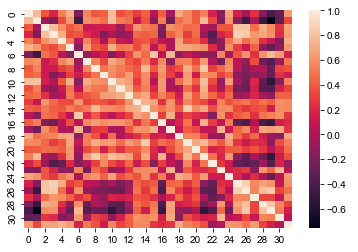

In [25]:
# visualize correlation matrix or digits 1, 6, 8 on encoded data
cor1 = np.corrcoef(dfxtrain1.T)
sns.heatmap(cor1)
sns.set(rc={'figure.figsize':(6, 3)})

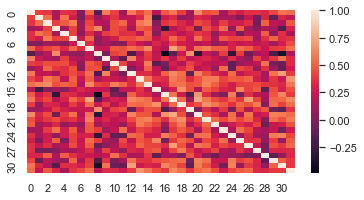

In [26]:
cor6 = np.corrcoef(dfxtrain6.T)
sns.heatmap(cor6)
sns.set(rc={'figure.figsize':(6, 3)})

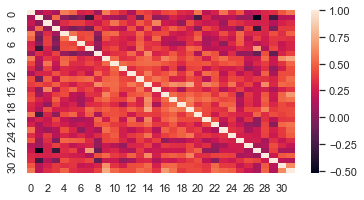

In [27]:
cor8 = np.corrcoef(dfxtrain8.T)
sns.heatmap(cor8)
sns.set(rc={'figure.figsize':(6, 3)})

## 5. Naive Bayes Classifier

In [28]:
from sklearn.naive_bayes import GaussianNB

# create model
clf = GaussianNB()
clf.fit(df_encoded_train, ytrain)

# predictions
trg_pred = clf.predict(df_encoded_train)
trg_acc = accuracy_score(ytrain, trg_pred)

test_pred = clf.predict(df_encoded_test)
test_acc = accuracy_score(ytest, test_pred)

print(f"Training Accuracy : {trg_acc}")
print(f"Test Accuracy : {test_acc}")

Training Accuracy : 0.7236607142857143
Test Accuracy : 0.7280952380952381


In [29]:
from sklearn.naive_bayes import MultinomialNB

# create model
clf = MultinomialNB()
clf.fit(df_encoded_train, ytrain)

# predictions
trg_pred = clf.predict(df_encoded_train)
trg_acc = accuracy_score(ytrain, trg_pred)

test_pred = clf.predict(df_encoded_test)
test_acc = accuracy_score(ytest, test_pred)

print(f"Training Accuracy : {trg_acc}")
print(f"Test Accuracy : {test_acc}")


Training Accuracy : 0.8229464285714285
Test Accuracy : 0.8173809523809524


We will use the GaussianNB because the assumption for LDA is that the variables following multivariate normal distribution. So, we will use a fair comparison and use GaussianNB instead of MultinomialNB, even though MultinomialNB produces better results.

## 6. QDA Classifier

In [30]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# create model
qda = QuadraticDiscriminantAnalysis()
qda.fit(df_encoded_train, ytrain)

# predictions
trg_pred = qda.predict(df_encoded_train)
trg_acc = accuracy_score(ytrain, trg_pred)

test_pred = qda.predict(df_encoded_test)
test_acc = accuracy_score(ytest, test_pred)

print(f"Training Accuracy : {trg_acc}")
print(f"Test Accuracy : {test_acc}")


Training Accuracy : 0.9634821428571428
Test Accuracy : 0.9619047619047619
